In [1]:
import numpy as np
import random
from utils import *
from train import train_2l,train_1,train_3l
import matplotlib.pyplot as plt
import networkx as nx

In [25]:
'''
def get_training_adj_lists(labels, adj_lists,seed):
    np.random.seed(seed)
    random.seed(seed)
    num_nodes = labels.shape[0]
    rand_indices = np.random.permutation(num_nodes)
    train = rand_indices[:int(num_nodes*0.6)]
    valid = rand_indices[int(num_nodes*0.6):int(num_nodes*0.8)]
    test = (rand_indices[int(num_nodes*0.8):])    
    train_and_valid = rand_indices[:int(num_nodes*0.8)]
    
    adj_lists_train = defaultdict(set)
    adj_lists_valid = defaultdict(set)
    adj_lists_test = defaultdict(set)
    for key in adj_lists:
        if key in train:
            nodes = []
            for node in adj_lists[key]:
                if node in train:
                    nodes.append(node)
            nodes = set(nodes)
            adj_lists_train[key] = nodes
            
    for key in adj_lists:
        if key in valid:
            nodes = []
            for node in adj_lists[key]:
                if node in valid:
                    nodes.append(node)
            nodes = set(nodes)
            adj_lists_valid[key] = nodes
            
    for key in adj_lists:
        if key in test:
            nodes = []
            for node in adj_lists[key]:
                if node in test:
                    nodes.append(node)
            nodes = set(nodes)
            adj_lists_test[key] = nodes
    return adj_lists_train,adj_lists_valid,adj_lists_test,train,valid,test
def shuffle_edges(dict_edges,n_swap,n_try):
    G_ = nx.Graph(dict_edges)
    G_swap = nx.double_edge_swap(G_,n_swap,n_try)
    edge_list = list(nx.to_edgelist(G_swap))
    adj_lists = defaultdict(set)
    for i in range(len(edge_list)):
        adj_lists[edge_list[i][0]].add(edge_list[i][1])
        adj_lists[edge_list[i][1]].add(edge_list[i][0])    
    return adj_lists
'''

'\ndef get_training_adj_lists(labels, adj_lists,seed):\n    np.random.seed(seed)\n    random.seed(seed)\n    num_nodes = labels.shape[0]\n    rand_indices = np.random.permutation(num_nodes)\n    train = rand_indices[:int(num_nodes*0.6)]\n    valid = rand_indices[int(num_nodes*0.6):int(num_nodes*0.8)]\n    test = (rand_indices[int(num_nodes*0.8):])    \n    train_and_valid = rand_indices[:int(num_nodes*0.8)]\n    \n    adj_lists_train = defaultdict(set)\n    adj_lists_valid = defaultdict(set)\n    adj_lists_test = defaultdict(set)\n    for key in adj_lists:\n        if key in train:\n            nodes = []\n            for node in adj_lists[key]:\n                if node in train:\n                    nodes.append(node)\n            nodes = set(nodes)\n            adj_lists_train[key] = nodes\n            \n    for key in adj_lists:\n        if key in valid:\n            nodes = []\n            for node in adj_lists[key]:\n                if node in valid:\n                    nodes.app

In [2]:
def get_training_adj_lists(labels, adj_lists,seed):
    np.random.seed(seed)
    random.seed(seed)
    num_nodes = labels.shape[0]
    rand_indices = np.random.permutation(num_nodes)
    train = rand_indices[:int(num_nodes*0.6)]
    valid = rand_indices[int(num_nodes*0.6):int(num_nodes*0.8)]
    test = (rand_indices[int(num_nodes*0.8):])    
    train_and_valid = rand_indices[:int(num_nodes*0.8)]
    
    adj_lists_train = defaultdict(set)
    adj_lists_valid = defaultdict(set)
    for key in adj_lists:
        if key in train:
            nodes = []
            for node in adj_lists[key]:
                if node in train:
                    nodes.append(node)
            nodes = set(nodes)
            adj_lists_train[key] = nodes
    for key in adj_lists:
        if key in train_and_valid:
            nodes = []
            for node in adj_lists[key]:
                if node in train_and_valid:
                    nodes.append(node)
            nodes = set(nodes)
            adj_lists_valid[key] = nodes
    return adj_lists_train,adj_lists_valid,train,valid,test

def shuffle_edges(dict_edges,n_swap,n_try):
    G_ = nx.Graph(dict_edges)
    num_edges = nx.number_of_edges(G_)
    print(num_edges)
    print(num_edges*n_swap)
    G_swap = nx.double_edge_swap(G_,int(n_swap*num_edges),n_try*int(n_swap*num_edges))
    edge_list = list(nx.to_edgelist(G_swap))
    adj_lists = defaultdict(set)
    for i in range(len(edge_list)):
        adj_lists[edge_list[i][0]].add(edge_list[i][1])
        adj_lists[edge_list[i][1]].add(edge_list[i][0])    
    return adj_lists

In [3]:
feat_data,labels,full_adjs = load_data('pubmed',path='/home/zhihao/Document/gnn_fd/graphSage/data/')

In [6]:

results_mlp = []
    
for seed in range(10):
    import torch
    from torch import nn
    from torch.nn import ReLU
    
    from torch.autograd import Variable
    from sklearn.metrics import f1_score,accuracy_score
    import glob
    import os
    import time
    batch_size = 128
    t_total = time.time()
    loss_values = []
    loss_train = []
    bad_counter = 0
    epochs = 70
    best = epochs + 1
    best_epoch = 0   
    temp_path = './pubmed/'
    patience = 5
    num_class = 3
    hidden_num = 128
    lr = 0.0002
    #results = []
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    class MLPModel(nn.Module):
        def __init__(self,num_classes,hidden_dim,feature_dim):
            super(MLPModel,self).__init__()
            self.hidden = nn.Linear(feature_dim,hidden_dim)
            self.layer = nn.Linear(hidden_dim,num_classes)
            self.xent = nn.CrossEntropyLoss()
            self.act1 = ReLU()
        def forward(self,nodes):
            X = self.hidden(nodes)
            X = self.act1(X)
            scores = self.layer(X)
            return scores
        def loss(self,nodes,labels):
            scores = self.forward(nodes)
            return self.xent(scores,labels.squeeze())
        
    mlp = MLPModel(num_class,hidden_num,feat_data.shape[1] )
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mlp.parameters()), lr=lr)
    
    
    for epoch in range(epochs):
        random.shuffle(training)
        num_batches = int(len(training) / batch_size) + 1
        train_losses = []
        start_time = time.time()
        for batch in range(num_batches):   
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(training))
            batch_nodes = training[i_start:i_end]
            
            optimizer.zero_grad()
            loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            train_losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
    
        
        num_batches_valid = int(len(validation) / batch_size) 
        valid_losses = []
        for batch in range(num_batches_valid):
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(validation))
            batch_nodes = validation[i_start:i_end]
    
            loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            valid_losses.append(loss.data.item())
  
        
        loss_train.append(np.average(train_losses))
        loss_values.append(np.average(valid_losses))
        torch.save(mlp.state_dict(),temp_path+'{}.pkl'.format(epoch))
        if loss_values[-1] < best:
            best = loss_values[-1]
            best_epoch = epoch 
            bad_counter = 0
        else:
            bad_counter += 1
        if bad_counter == patience:
            break
        files = glob.glob(temp_path+'*.pkl')
        for file in files:
            epoch_nb = int(file[len(temp_path):].split('.')[0])
            if epoch_nb < best_epoch:
                os.remove(file)
    files = glob.glob(temp_path+'*.pkl')
    for file in files:
        epoch_nb = int(file[len(temp_path):].split('.')[0])
        if epoch_nb > best_epoch:
            os.remove(file)

    mlp.load_state_dict(torch.load(temp_path+'{}.pkl'.format(best_epoch)))        
    print(best_epoch)
    
    num_batches_test = int(len(testing) / batch_size) 
    test_outputs = []
    test_labels = []
    for batch in range(num_batches_test):
        i_start = batch * batch_size
        i_end = (batch + 1) * batch_size
        batch_nodes = testing[i_start:i_end]
        test_output = torch.zeros(batch_size,num_class)
        for i in range(3):
            test_output = test_output + mlp.forward(torch.Tensor(feat_data[np.array(batch_nodes)]))
        
        test_outputs.extend(list(test_output.data.cpu().numpy().argmax(axis=1)))
        test_labels.extend(list(labels[batch_nodes]))
        
    accuracy_score(test_labels,test_outputs)
    results_mlp.append([loss_train,loss_values,accuracy_score(test_labels,test_outputs)])

68
69
69
64
69
69
69
69
69
69


In [28]:
results_sagegcn_0 = []
for seed in range(5):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
    
    new_adjs = {}
    for key in full_adjs_shuffle:
        neighbs_set = full_adjs_shuffle[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs_shuffle[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    
    results_sagegcn_0.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,70,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128))

In [71]:
ratio_list = [x*0.05 for x in range(11)]
results_0 = []
num = 10
for ratio in ratio_list:
    full_adjs_shuffle = shuffle_edges(full_adjs,ratio,10)
    results_sagegcn_0 = []
    for seed in range(num):
        training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
        
        new_adjs = {}
        for key in full_adjs_shuffle:
            neighbs_set = full_adjs_shuffle[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(full_adjs_shuffle[node] & neighbs_set)
            new_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_adjs[key].add((node,n_list.count(node)))
        new_training_adjs = {}
        for key in training_adjs:
            neighbs_set = training_adjs[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(training_adjs[node] & neighbs_set)
            new_training_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_training_adjs[key].add((node,n_list.count(node)))
        
        results_sagegcn_0.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,70,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128))    
    result_0 = []
    for i in range(num):
        result_0.append(results_sagegcn_0[i][2])
    results_0.append(result_0)



44327
0.0
44327
2216.35
44327
4432.7
44327
6649.050000000001
44327
8865.4
44327
11081.75
44327
13298.100000000002
44327
15514.45
44327
17730.8
44327
19947.15
44327
22163.5


In [33]:
results_sagegcn_2 = []
for seed in range(5):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
    
    new_adjs = {}
    for key in full_adjs_shuffle:
        neighbs_set = full_adjs_shuffle[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs_shuffle[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    
    results_sagegcn_2.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,2,70,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128)
)

In [9]:
results_sagegcn_best = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
    res = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,3,'./pubmed/',hidden=128,lr=0.0002,batch_size=128)   
    for i in range(5,16):
        temp = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.2*i,100,5,3,'./pubmed/',hidden=128,lr=0.0002,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    
    results_sagegcn_best.append(res)






In [ ]:
ratio_list = [x*0.05 for x in range(11)]
results_best = []
results_best_r = []
num = 10

for ratio in ratio_list:
    full_adjs_shuffle = shuffle_edges(full_adjs,ratio,10)
    results_sagegcn_best = []
    results_sagegcn_best_r = []
    for seed in range(num):
        training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs_shuffle,seed)
        
        new_adjs = {}
        for key in full_adjs_shuffle:
            neighbs_set = full_adjs_shuffle[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(full_adjs_shuffle[node] & neighbs_set)
            new_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_adjs[key].add((node,n_list.count(node)))
        new_training_adjs = {}
        for key in training_adjs:
            neighbs_set = training_adjs[key] | set([key])
            n_list = []
            for node in neighbs_set:
                n_list.extend(training_adjs[node] & neighbs_set)
            new_training_adjs[key] = set()
            
            neighbs_set.remove(key)
            for node in neighbs_set:
                new_training_adjs[key].add((node,n_list.count(node)))
                
        res = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.6,100,5,3,'./pubmed/',hidden=128,lr=0.0002,batch_size=128)   
        r = 0.6
        for i in range(4,16):
            temp = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.2*i,100,5,3,'./pubmed/',hidden=128,lr=0.0002,batch_size=128)
            if res[2] < temp[2]:
                res = temp    
                r = i * 0.2
        results_sagegcn_best.append(res)
        results_sagegcn_best_r.append(r)
    
    result_best = []
    for i in range(num):
        result_best.append(results_sagegcn_best[i][2])
    results_best.append(result_best)
    results_best_r.append(results_sagegcn_best_r)



44327
0.0


In [ ]:
import pickle
def save_list(path,list_):
    file = open(path,'wb')
    pickle.dump(list_,file)
    file.close()

In [16]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/pubmed/mlp.pkl',results_mlp)

In [76]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/pubmed/sage_0_randomedge.pkl',results_0)

In [77]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/pubmed/sage_best_randomedge.pkl',results_best)

In [ ]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/pubmed/sage_best_randomedge_r.pkl',results_best_r)

In [19]:
training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,0)

In [20]:
batch_size = 128
t_total = time.time()
loss_values = []
loss_train = []
bad_counter = 0
epochs = 100
best = epochs + 1
best_epoch = 0   
temp_path = './pubmed/'
patience = 100
num_class = 3
hidden_num = 128
lr = 0.0002

mlp = MLPModel(num_class,hidden_num,feat_data.shape[1] )
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mlp.parameters()), lr=lr)


for epoch in range(epochs):
    random.shuffle(training)
    num_batches = int(len(training) / batch_size) + 1
    train_losses = []
    start_time = time.time()
    for batch in range(num_batches):   
        i_start = batch * batch_size
        i_end = min((batch + 1) * batch_size, len(training))
        batch_nodes = training[i_start:i_end]
        
        optimizer.zero_grad()
        loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
        
        train_losses.append(loss.data.item())
        loss.backward()
        optimizer.step()

    
    num_batches_valid = int(len(validation) / batch_size) 
    valid_losses = []
    for batch in range(num_batches_valid):
        i_start = batch * batch_size
        i_end = min((batch + 1) * batch_size, len(validation))
        batch_nodes = validation[i_start:i_end]

        loss = mlp.loss(Variable(torch.Tensor(feat_data[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
        
        valid_losses.append(loss.data.item())

    
    loss_train.append(np.average(train_losses))
    loss_values.append(np.average(valid_losses))
    torch.save(mlp.state_dict(),temp_path+'{}.pkl'.format(epoch))
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch 
        bad_counter = 0
    else:
        bad_counter += 1
    if bad_counter == patience:
        break
    files = glob.glob(temp_path+'*.pkl')
    for file in files:
        epoch_nb = int(file[len(temp_path):].split('.')[0])
        if epoch_nb < best_epoch:
            os.remove(file)
files = glob.glob(temp_path+'*.pkl')
for file in files:
    epoch_nb = int(file[len(temp_path):].split('.')[0])
    if epoch_nb > best_epoch:
        os.remove(file)
mlp.load_state_dict(torch.load(temp_path+'{}.pkl'.format(best_epoch)))        
print(best_epoch)

num_batches_test = int(len(testing) / batch_size) 
test_outputs = []
test_labels = []
for batch in range(num_batches_test):
    i_start = batch * batch_size
    i_end = (batch + 1) * batch_size
    batch_nodes = testing[i_start:i_end]
    test_output = torch.zeros(batch_size,num_class)
    for i in range(3):
        test_output = test_output + mlp.forward(torch.Tensor(feat_data[np.array(batch_nodes)]))
    test_outputs.extend(list(test_output.data.cpu().numpy().argmax(axis=1)))
    test_labels.extend(list(labels[batch_nodes]))
    
loss_mlp = [loss_train,loss_values]

98


In [37]:
    #new_adjs = {}
    #for key in full_adjs:
    #    neighbs_set = full_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(full_adjs[node] & neighbs_set)
    #    new_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_adjs[key].add((node,n_list.count(node)))
    #new_training_adjs = {}
    #for key in training_adjs:
    #    neighbs_set = training_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(training_adjs[node] & neighbs_set)
    #    new_training_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_training_adjs[key].add((node,n_list.count(node)))
    
    loss_sage = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,100,3,'./pubmed/',hidden=128,lr=0.0002,batch_size=128)

In [47]:
    #new_adjs = {}
    #for key in full_adjs:
    #    neighbs_set = full_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(full_adjs[node] & neighbs_set)
    #    new_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_adjs[key].add((node,n_list.count(node)))
    #new_training_adjs = {}
    #for key in training_adjs:
    #    neighbs_set = training_adjs[key] | set([key])
    #    n_list = []
    #    for node in neighbs_set:
    #        n_list.extend(training_adjs[node] & neighbs_set)
    #    new_training_adjs[key] = set()
    #    
    #    neighbs_set.remove(key)
    #    for node in neighbs_set:
    #        new_training_adjs[key].add((node,n_list.count(node)))
    
    loss_ncgnn = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,1.5,100,100,3,'./pubmed/',hidden=128,lr=0.0002,batch_size=128)

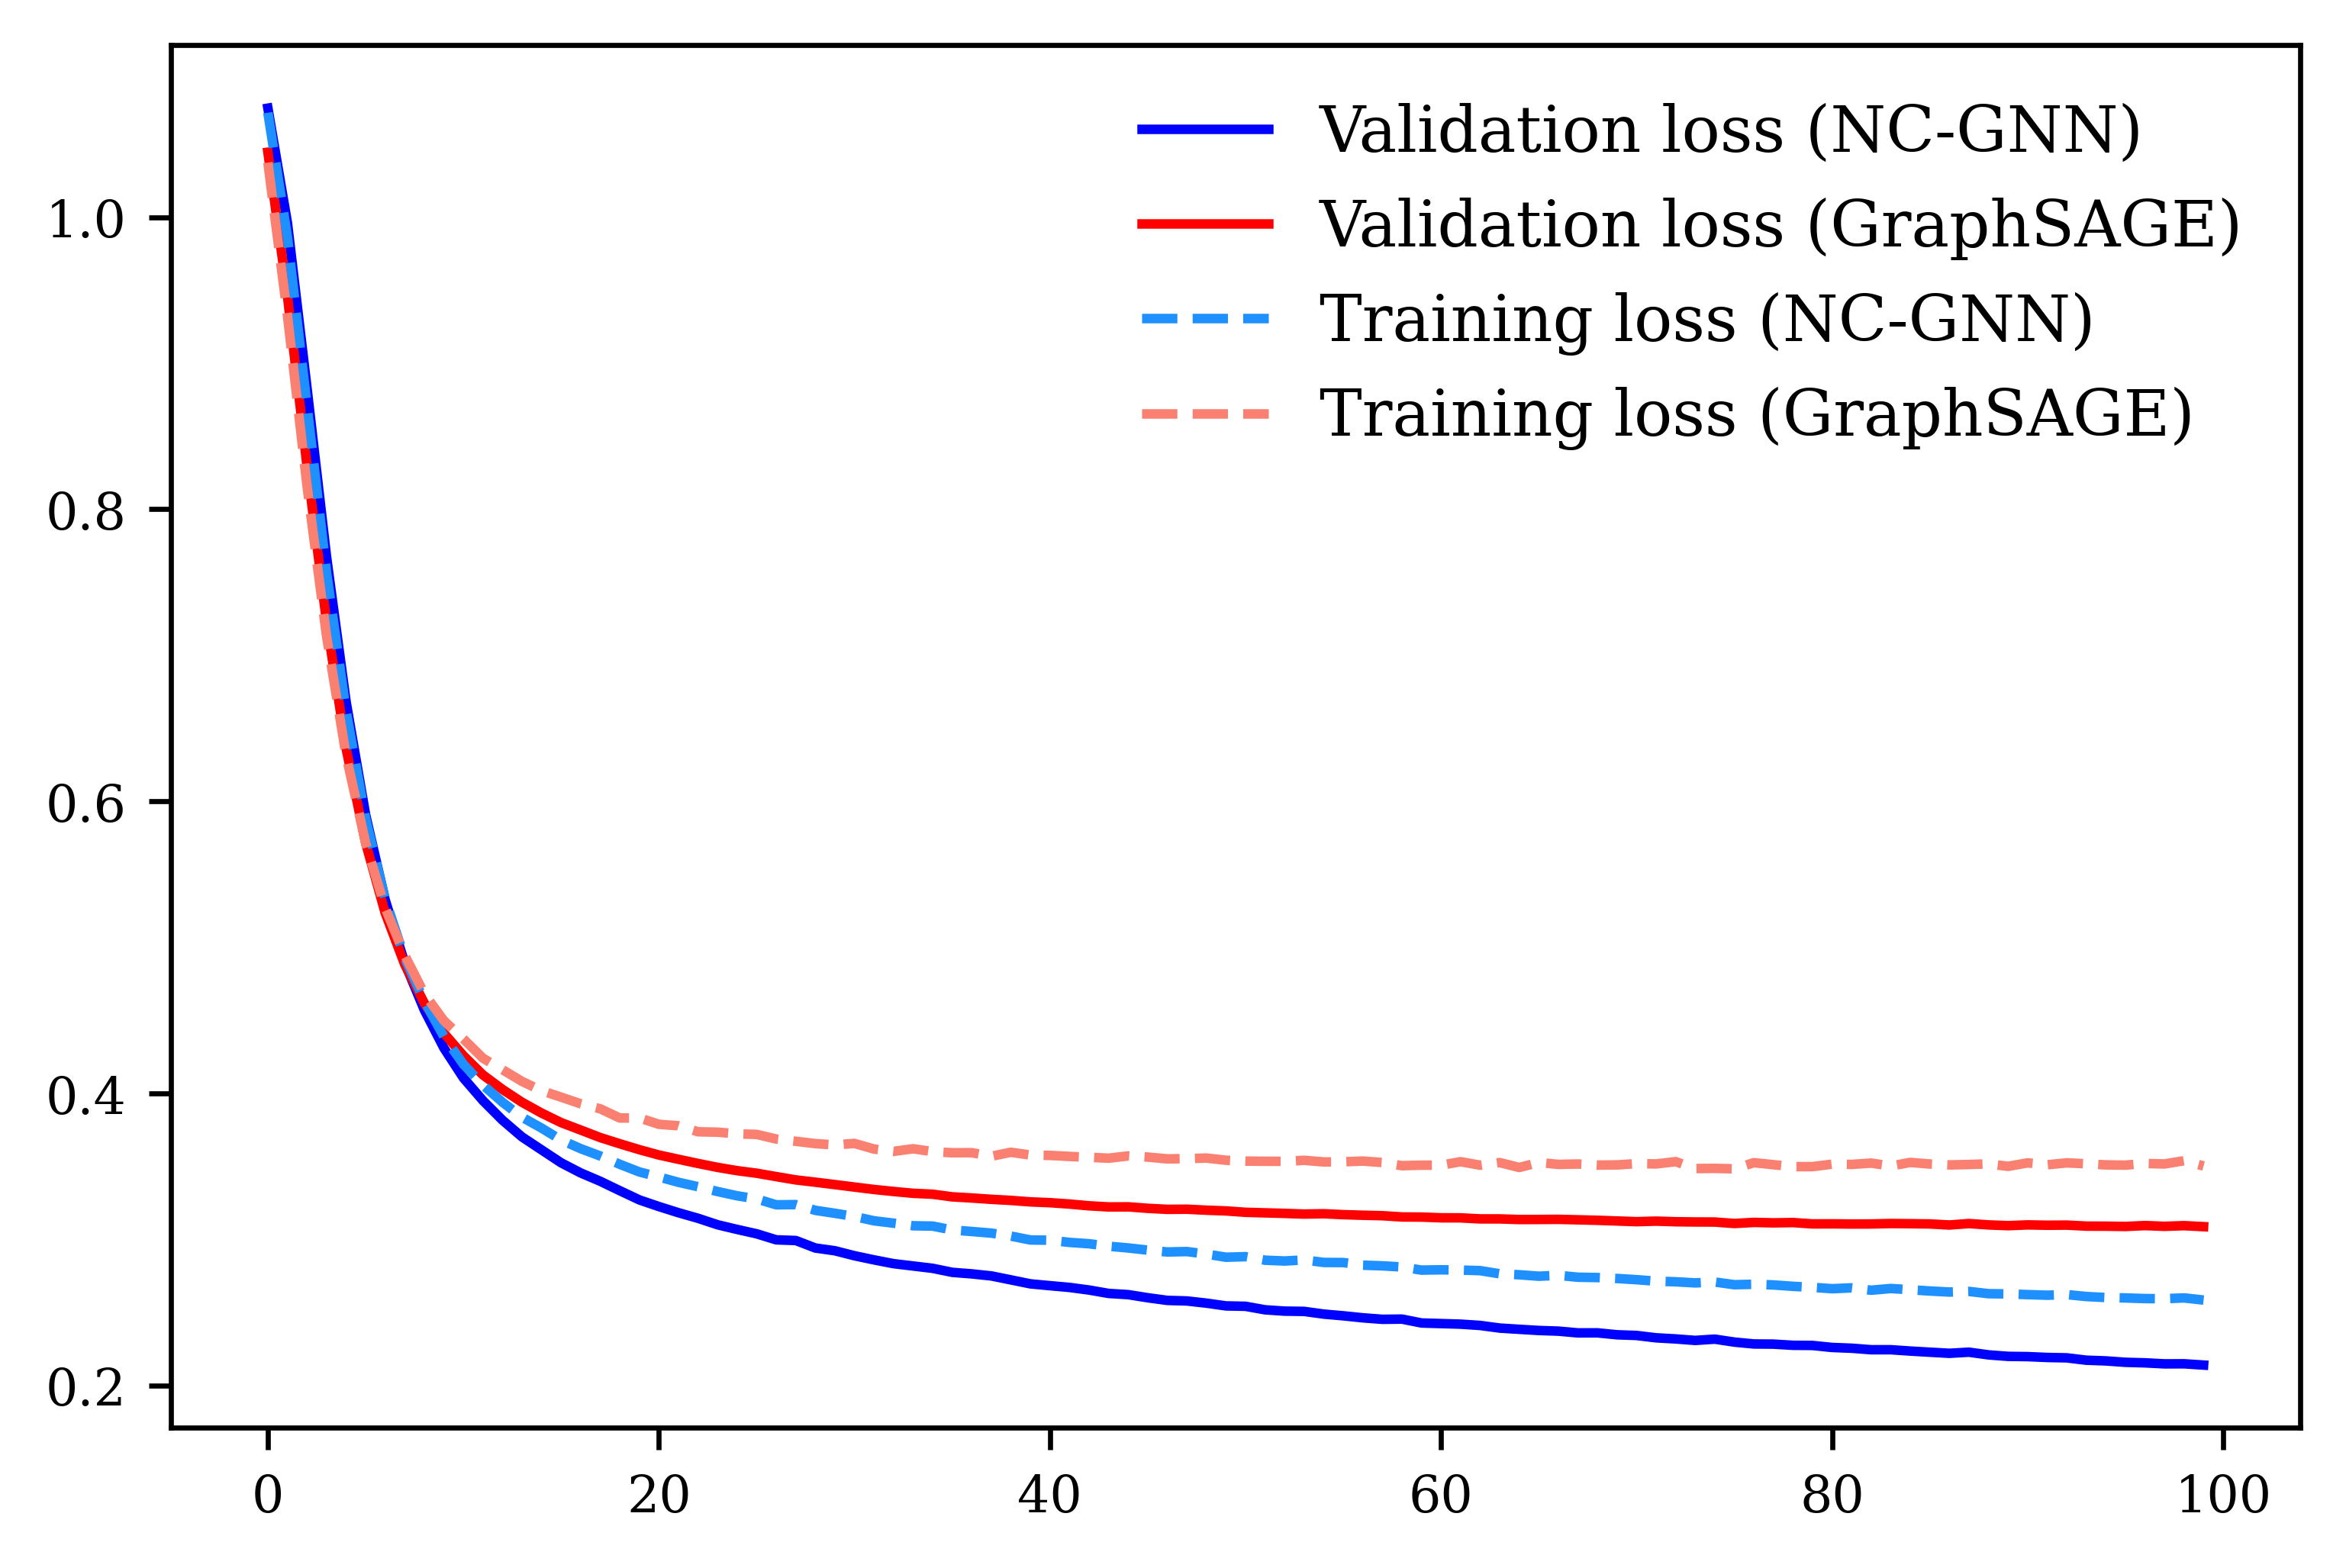

In [40]:
import matplotlib.pyplot as plt
with plt.style.context(['ieee']): 
    fig, ax = plt.subplots(figsize=(6,4))

    ax.plot(loss_ncgnn[0],'-',color='b',label='Validation loss (NC-GNN)')
    ax.plot(loss_ncgnn[1],'-',color='r',label='Validation loss (GraphSAGE)')
    ax.plot(loss_sage[0],'--',color='dodgerblue',label='Training loss (NC-GNN)')
    ax.plot(loss_sage[1],'--',color='salmon',label='Training loss (GraphSAGE)')
    ax.legend(fontsize=10,loc=1,frameon=False)

In [41]:
save_list('/Users/zhihaodong/Downloads/Document/gnn_fd/graphSage/split/multihead/results/pubmed/loss.pkl',[loss_mlp,loss_sage,loss_ncgnn])

In [8]:
training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,0)

In [9]:
    acc_lists = []    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
    #res = train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,100,5,7,'./cora/',hidden=128,lr=0.0002,batch_size=128)   
    for j in range(20):
        acc_list = []
        for i in range(0,11):
            acc_list.append(train_1(False,True,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0.4*i,100,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128)[2])
        acc_lists.append(acc_list)

In [ ]:
acc_array = np.array(acc_lists)

In [ ]:
import matplotlib.pyplot as plt

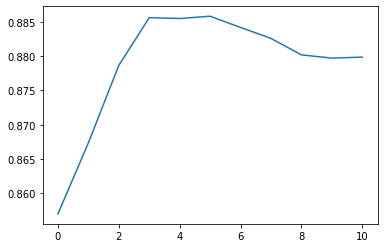

In [ ]:
plt.plot(np.mean(acc_array,axis=0))

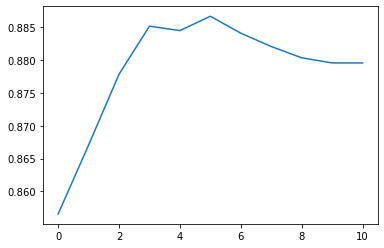

In [51]:
plt.plot(np.mean(acc_array,axis=0))

In [14]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/pubmed/acc_array_20.pkl',acc_array)

# concatenation

In [7]:
cancat_results_sagegcn_0_1 = []
cancat_results_sagegcn_0_2l = []
cancat_results_sagegcn_0_3l = []

for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
    cancat_results_sagegcn_0_1.append(train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128))        
    cancat_results_sagegcn_0_2l.append(train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128))
    cancat_results_sagegcn_0_3l.append(train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128))



In [9]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/pubmed/concat/sage_0_1.pkl',cancat_results_sagegcn_0_1)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/pubmed/concat/sage_0_2l.pkl',cancat_results_sagegcn_0_2l)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/pubmed/concat/sage_0_3l.pkl',cancat_results_sagegcn_0_3l)

In [10]:
a = []
for i in cancat_results_sagegcn_0_1:
    a.append(i[2])
sum(a)

8.857552083333333

In [11]:
a = []
for i in cancat_results_sagegcn_0_2l:
    a.append(i[2])
sum(a)

8.881510416666666

In [12]:
a = []
for i in cancat_results_sagegcn_0_3l:
    a.append(i[2])
sum(a)

8.878385416666667

In [ ]:
cancat_results_sagegcn_best_1 = []
cancat_results_sagegcn_best_2l = []
cancat_results_sagegcn_best_3l = []
for seed in range(10):
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))
            
    res = train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128)   
    for i in range(1,11):
        temp = train_1(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0.3*i,500,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    cancat_results_sagegcn_best_1.append(res)
    
    res = train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128)   
    for i in range(1,11):
        temp = train_2l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0.3*i,500,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    cancat_results_sagegcn_best_2l.append(res)
    
    res = train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0,500,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128)   
    for i in range(1,11):
        temp = train_3l(False,False,feat_data,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,10,0.3*i,500,5,3,'./pubmed/',hidden=128,lr=0.0005,batch_size=128)
        if res[2] < temp[2]:
            res = temp 
    cancat_results_sagegcn_best_3l.append(res)


In [ ]:
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/pubmed/concat/sage_best_1.pkl',cancat_results_sagegcn_best_1)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/pubmed/concat/sage_best_2l.pkl',cancat_results_sagegcn_best_2l)
save_list('/home/zhihao/Document/gnn_fd/graphSage/split/multihead/results/pubmed/concat/sage_best_3l.pkl',cancat_results_sagegcn_best_3l)

In [18]:
a = []
for i in cancat_results_sagegcn_best_1:
    a.append(i[2])
sum(a)

8.863020833333334

In [19]:
a = []
for i in cancat_results_sagegcn_best_2l:
    a.append(i[2])
sum(a)

8.8984375

In [20]:
a = []
for i in cancat_results_sagegcn_best_3l:
    a.append(i[2])
sum(a)

8.906510416666666

In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)

In [64]:
feat_data_half = pca.fit_transform(feat_data)

In [87]:
feat_data_half = feat_data[:,:200]

In [95]:

results_mlp_r = []
    
for seed in range(5):
    import torch
    from torch import nn
    from torch.nn import ReLU
    
    from torch.autograd import Variable
    from sklearn.metrics import f1_score,accuracy_score
    import glob
    import os
    import time
    batch_size = 128
    t_total = time.time()
    loss_values = []
    loss_train = []
    bad_counter = 0
    epochs = 200
    best = epochs + 1
    best_epoch = 0   
    temp_path = './pubmed/'
    patience = 5
    num_class = 3
    hidden_num = 128
    lr = 0.0008
    #results = []
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,seed)
    class MLPModel(nn.Module):
        def __init__(self,num_classes,hidden_dim,feature_dim):
            super(MLPModel,self).__init__()
            self.hidden = nn.Linear(feature_dim,hidden_dim)
            self.layer = nn.Linear(hidden_dim,num_classes)
            self.xent = nn.CrossEntropyLoss()
            self.act1 = ReLU()
        def forward(self,nodes):
            X = self.hidden(nodes)
            X = self.act1(X)
            scores = self.layer(X)
            return scores
        def loss(self,nodes,labels):
            scores = self.forward(nodes)
            return self.xent(scores,labels.squeeze())
        
    mlp = MLPModel(num_class,hidden_num,feat_data_half.shape[1] )
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mlp.parameters()), lr=lr)
    
    
    for epoch in range(epochs):
        random.shuffle(training)
        num_batches = int(len(training) / batch_size) + 1
        train_losses = []
        start_time = time.time()
        for batch in range(num_batches):   
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(training))
            batch_nodes = training[i_start:i_end]
            
            optimizer.zero_grad()
            loss = mlp.loss(Variable(torch.Tensor(feat_data_half[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            train_losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
    
        
        num_batches_valid = int(len(validation) / batch_size) 
        valid_losses = []
        for batch in range(num_batches_valid):
            i_start = batch * batch_size
            i_end = min((batch + 1) * batch_size, len(validation))
            batch_nodes = validation[i_start:i_end]
    
            loss = mlp.loss(Variable(torch.Tensor(feat_data_half[np.array(batch_nodes)])),Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
            
            valid_losses.append(loss.data.item())
  
        
        loss_train.append(np.average(train_losses))
        loss_values.append(np.average(valid_losses))
        torch.save(mlp.state_dict(),temp_path+'{}.pkl'.format(epoch))
        if loss_values[-1] < best:
            best = loss_values[-1]
            best_epoch = epoch 
            bad_counter = 0
        else:
            bad_counter += 1
        if bad_counter == patience:
            break
        files = glob.glob(temp_path+'*.pkl')
        for file in files:
            epoch_nb = int(file[len(temp_path):].split('.')[0])
            if epoch_nb < best_epoch:
                os.remove(file)
    files = glob.glob(temp_path+'*.pkl')
    for file in files:
        epoch_nb = int(file[len(temp_path):].split('.')[0])
        if epoch_nb > best_epoch:
            os.remove(file)

    mlp.load_state_dict(torch.load(temp_path+'{}.pkl'.format(best_epoch)))        
    print(best_epoch)
    
    num_batches_test = int(len(testing) / batch_size) 
    test_outputs = []
    test_labels = []
    for batch in range(num_batches_test):
        i_start = batch * batch_size
        i_end = (batch + 1) * batch_size
        batch_nodes = testing[i_start:i_end]
        test_output = torch.zeros(batch_size,num_class)
        for i in range(3):
            test_output = test_output + mlp.forward(torch.Tensor(feat_data_half[np.array(batch_nodes)]))
        
        test_outputs.extend(list(test_output.data.cpu().numpy().argmax(axis=1)))
        test_labels.extend(list(labels[batch_nodes]))
        
    accuracy_score(test_labels,test_outputs)
    results_mlp_r.append([loss_train,loss_values,accuracy_score(test_labels,test_outputs)])

97
106
78
106
92


In [101]:
a = []
for i in results_mlp:
    a.append(i[2])
a

[0.8697916666666666,
 0.8763020833333334,
 0.8815104166666666,
 0.8776041666666666,
 0.8786458333333333,
 0.8713541666666667,
 0.8674479166666667,
 0.87578125,
 0.8697916666666666,
 0.8791666666666667]

In [72]:
a = []
for i in results_sagegcn_best:
    a.append(i[2])
a

[0.8864583333333333,
 0.8911458333333333,
 0.8880208333333334,
 0.88828125,
 0.8908854166666667,
 0.8932291666666666,
 0.8927083333333333,
 0.8971354166666666,
 0.8934895833333333,
 0.8971354166666666]

In [4]:
    training_adjs,valid_adjs,training,validation,testing = get_training_adj_lists(labels,full_adjs,0)
    
    new_adjs = {}
    for key in full_adjs:
        neighbs_set = full_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(full_adjs[node] & neighbs_set)
        new_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_adjs[key].add((node,n_list.count(node)))
    new_training_adjs = {}
    for key in training_adjs:
        neighbs_set = training_adjs[key] | set([key])
        n_list = []
        for node in neighbs_set:
            n_list.extend(training_adjs[node] & neighbs_set)
        new_training_adjs[key] = set()
        
        neighbs_set.remove(key)
        for node in neighbs_set:
            new_training_adjs[key].add((node,n_list.count(node)))

    train_1(False,True,feat_data_half,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,2,300,5,3,'./pubmed/',hidden=128,lr=0.001,batch_size=128)

NameError: name 'feat_data_half' is not defined

In [99]:
train_1(False,True,feat_data_half,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,0,300,5,3,'./pubmed/',hidden=128,lr=0.001,batch_size=128)[2]

0.8294270833333334

In [100]:
train_1(False,True,feat_data_half,labels,new_adjs,new_training_adjs,new_adjs,training,validation,testing,10,20,1,300,5,3,'./pubmed/',hidden=128,lr=0.001,batch_size=128)[2]

0.84140625

# structure analysis

In [103]:
import networkx as nx

In [104]:
G_ = nx.Graph(full_adjs)

In [105]:
G_.number_of_edges()

44327

In [106]:
G_.number_of_nodes()

19717

In [38]:
emb_layer = nn.Embedding(vocab_size, emb_dim)
word_vectors = emb_layer(torch.LongTensor(encoded_sentences))

In [39]:
emb_layer.weight.requires_grad

True

In [47]:
vocab = Counter(words)
vocab

Counter({'i': 2,
         'am': 2,
         'new': 1,
         'to': 1,
         'PyTorch': 1,
         'having': 1,
         'fun': 1})

In [40]:
word2idx = {word: ind for ind, word in enumerate(vocab)} 
word2idx

{'i': 0, 'am': 1, 'new': 2, 'to': 3, 'PyTorch': 4, 'having': 5, 'fun': 6}

In [41]:
encoded_sentences = [word2idx[word] for word in words]
encoded_sentences

[0, 1, 2, 3, 4, 0, 1, 5, 6]

In [43]:
emb_layer.

Parameter containing:
tensor([[ 1.0437, -1.0473,  0.0988],
        [-1.5288, -0.8100, -0.2116],
        [-0.4282,  0.5499,  1.3648],
        [ 1.6610,  1.3286, -0.3298],
        [ 1.1822,  0.3126,  0.6502],
        [ 0.3293,  0.1529,  1.7215],
        [ 1.4224,  1.8458, -0.4730]], requires_grad=True)

In [44]:
word_vectors = emb_layer(torch.LongTensor(encoded_sentences))

In [51]:
a = word_vectors.detach().clone()

In [52]:
a


tensor([[ 1.0437, -1.0473,  0.0988],
        [-1.5288, -0.8100, -0.2116],
        [-0.4282,  0.5499,  1.3648],
        [ 1.6610,  1.3286, -0.3298],
        [ 1.1822,  0.3126,  0.6502],
        [ 1.0437, -1.0473,  0.0988],
        [-1.5288, -0.8100, -0.2116],
        [ 0.3293,  0.1529,  1.7215],
        [ 1.4224,  1.8458, -0.4730]])

In [53]:
word_vectors.repeat(2,1)

tensor([[ 1.0437, -1.0473,  0.0988],
        [-1.5288, -0.8100, -0.2116],
        [-0.4282,  0.5499,  1.3648],
        [ 1.6610,  1.3286, -0.3298],
        [ 1.1822,  0.3126,  0.6502],
        [ 1.0437, -1.0473,  0.0988],
        [-1.5288, -0.8100, -0.2116],
        [ 0.3293,  0.1529,  1.7215],
        [ 1.4224,  1.8458, -0.4730],
        [ 1.0437, -1.0473,  0.0988],
        [-1.5288, -0.8100, -0.2116],
        [-0.4282,  0.5499,  1.3648],
        [ 1.6610,  1.3286, -0.3298],
        [ 1.1822,  0.3126,  0.6502],
        [ 1.0437, -1.0473,  0.0988],
        [-1.5288, -0.8100, -0.2116],
        [ 0.3293,  0.1529,  1.7215],
        [ 1.4224,  1.8458, -0.4730]], grad_fn=<RepeatBackward>)

In [56]:
a.view(9,-1)

tensor([[ 1.0437, -1.0473,  0.0988],
        [-1.5288, -0.8100, -0.2116],
        [-0.4282,  0.5499,  1.3648],
        [ 1.6610,  1.3286, -0.3298],
        [ 1.1822,  0.3126,  0.6502],
        [ 1.0437, -1.0473,  0.0988],
        [-1.5288, -0.8100, -0.2116],
        [ 0.3293,  0.1529,  1.7215],
        [ 1.4224,  1.8458, -0.4730]])